In [10]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from scipy.interpolate import griddata

In [11]:
with open('graph_objects/G_simple_directed_iggielgn.pickle', 'rb') as f:
    G_simple_directed = pickle.load(f)
    G_simple_directed.name = 'G_simple_directed'

In [12]:
# Dataset; 'iggin' or 'iggielgn'
dataset = 'iggielgn'

# S-t-flow; 's-t-degree' or 's-t-type'
s_t_flow = 'hybrid'

# Analysis; 'centrality' or 'max_flow'
analysis = 'centrality'

In [13]:
# MAX FLOW
node_removals_df = pd.read_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/wfcr_node_removal_df.pkl')
edge_removals_df = pd.read_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/wfcr_edge_removal_df.pkl')

In [14]:
# CENTRALITY
# node_removals_df = pd.read_pickle('results/centrality/iggielgn/greedy_node_removal.pkl').head(50)
# edge_removals_df = pd.read_pickle('results/centrality/iggielgn/greedy_edge_removal.pkl').head(50)

# Network Impact Heatmap
Based on impact on evaluated metric by given removal

### Node

In [15]:
# metric; 'capacity_robustness_max_flow' or 'composite'
metric = 'capacity_robustness_max_flow'
df = node_removals_df.copy()
df[metric+'_diff'] = df[metric].diff().abs()

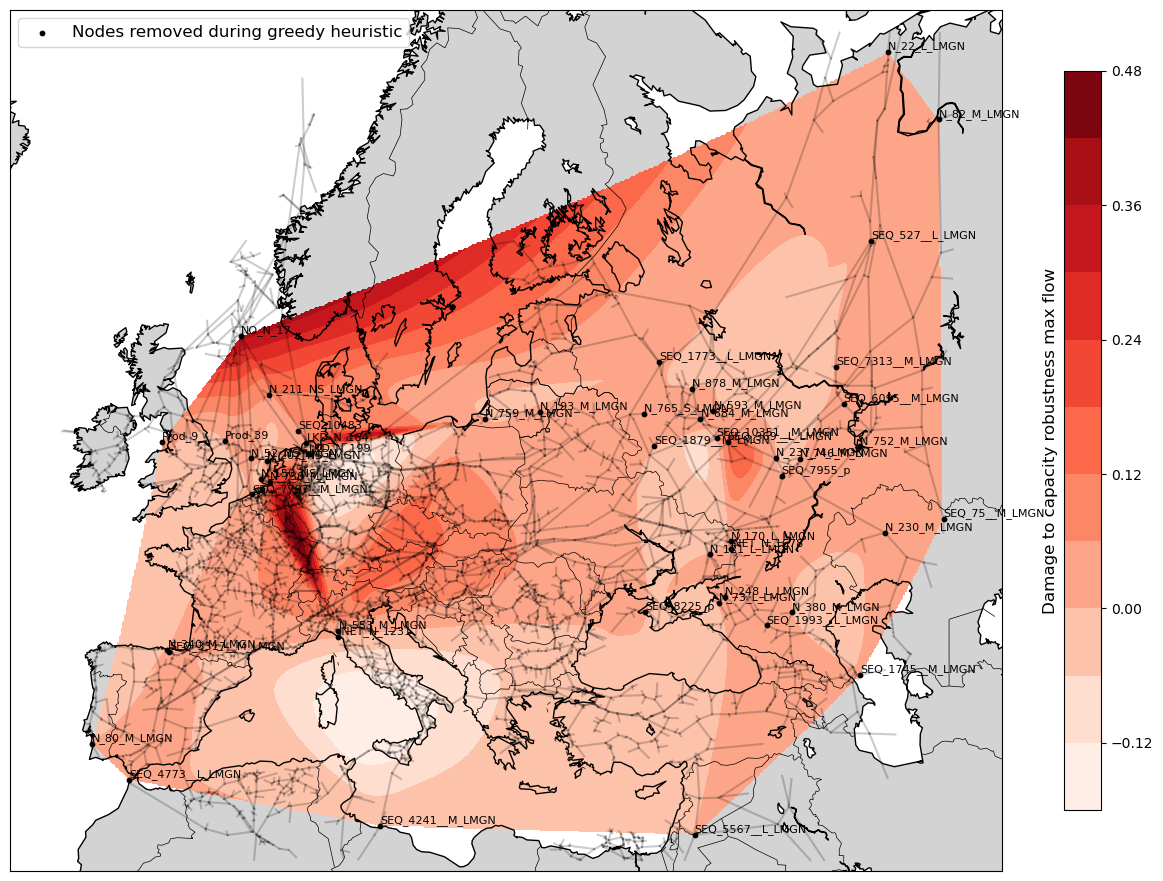

In [16]:
# Get the latitude and longitude of nodes present in the DataFrame
df = df.iloc[1:]

nodes_in_df = df['removed_entity'].values
lats = [G_simple_directed.nodes[node]['lat'] for node in nodes_in_df if node in G_simple_directed.nodes()]
lons = [G_simple_directed.nodes[node]['long'] for node in nodes_in_df if node in G_simple_directed.nodes()]

# Create a grid for interpolation
lon_min, lon_max = min(lons), max(lons)
lat_min, lat_max = min(lats), max(lats)
num_points = 500
lons_interp = np.linspace(lon_min, lon_max, num_points)
lats_interp = np.linspace(lat_min, lat_max, num_points)
lons_mesh, lats_mesh = np.meshgrid(lons_interp, lats_interp)

# Convert the latitude and longitude of nodes in the DataFrame to numpy array
points = np.array(list(zip(lons, lats)))

# Remove NaN values from the values array
values = df[metric+'_diff'].values
mask = ~np.isnan(values)
values = values[mask]
points = points[mask]

# Interpolate the metric values on the grid
metric_interp = griddata(points, values, (lons_mesh, lats_mesh), method='cubic')

plt.figure(figsize=(16, 16)) 

# Plot the map
m = Basemap(projection='merc', llcrnrlat=30, urcrnrlat=69, llcrnrlon=-15, urcrnrlon=60, resolution='l')
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='lightgray')

# Plot the interpolated heatmap
x_interp, y_interp = m(lons_mesh, lats_mesh)
sc = m.contourf(x_interp, y_interp, metric_interp, cmap='Reds', levels=10)

# Add colorbar
cbar = plt.colorbar(sc, shrink=0.6, aspect=20)
cbar.ax.yaxis.set_label_position('left')
cbar.set_label('Damage to capacity robustness max flow', fontsize=12)

# Plot the points themselves
x, y = m(lons, lats)
m.scatter(x, y, c='black', marker='o', s=10, label='Nodes removed during greedy heuristic') 

for label, x, y in zip(nodes_in_df, x, y):
    plt.text(x, y, label, fontsize=8, ha='left', va='bottom', color='black')

# Plot the all the edges in G_simple_directed
for u, v in G_simple_directed.edges():
    x, y = m([G_simple_directed.nodes[u]['long'], G_simple_directed.nodes[v]['long']], [G_simple_directed.nodes[u]['lat'], G_simple_directed.nodes[v]['lat']])
    m.plot(x, y, 'k-', alpha=0.2)

plt.legend(loc='upper left', fontsize=12)  

plt.savefig('saved_plots/heatmaps/'+analysis+'/node_network_impact_heatmap.png')

plt.show()


# Network Zone Heatmap
Heat based on the order in which the nodes were removed, to identify critical zones based on priority

In [17]:
# Create a new column in df that assigns an important metric to each 'removed_entity' based on how early it was removed (i.e., index)
df = node_removals_df.copy().iloc[1:]
df['importance'] = df.index.values
df['importance'] = df['importance'].max() - df['importance']
df['importance'] = df['importance']/df['importance'].max()


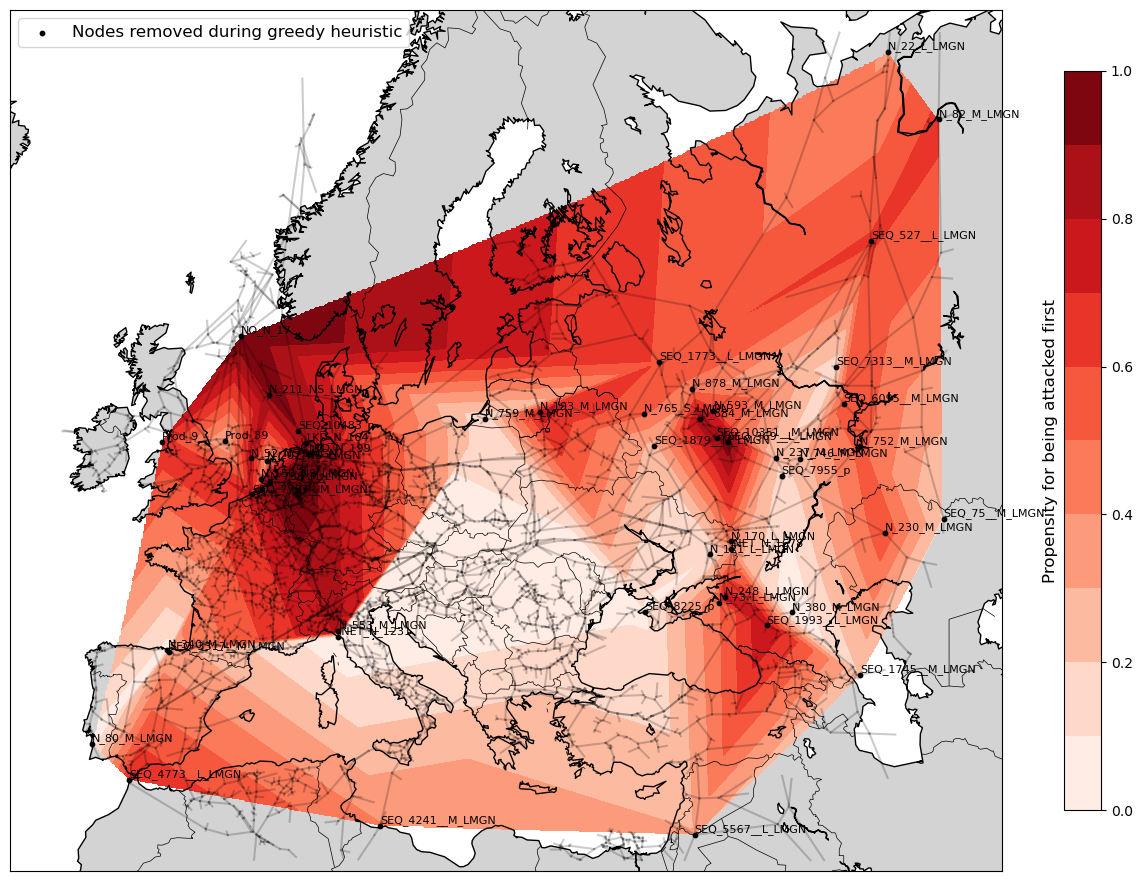

In [18]:
values = df['importance'].values
mask = ~np.isnan(values)
values, points = values[mask], points[mask]

# Interpolate the metric values on the grid
metric_interp = griddata(points, values, (lons_mesh, lats_mesh), method='linear')

plt.figure(figsize=(16, 16))

# Plot the map
m = Basemap(projection='merc', llcrnrlat=30, urcrnrlat=69, llcrnrlon=-15, urcrnrlon=60, resolution='l')
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='lightgrey')

# Plot the interpolated heatmap
sc = m.contourf(*m(lons_mesh, lats_mesh), metric_interp, cmap='Reds', levels=10)

# Add colorbar
cbar = plt.colorbar(sc, shrink=0.6, aspect=20)
cbar.ax.yaxis.set_label_position('left')
cbar.set_label('Propensity for being attacked first', fontsize=12)

# Plot the points themselves
m.scatter(*m(lons, lats), c='black', marker='o', s=10, label='Nodes removed during greedy heuristic')  
for label, x, y in zip(nodes_in_df, *m(lons, lats)):
    plt.text(x, y, label, fontsize=8, ha='left', va='bottom', color='black')  

# Plot all the edges in G_simple_directed
for u, v in G_simple_directed.edges():
    m.plot(*m([G_simple_directed.nodes[u]['long'], G_simple_directed.nodes[v]['long']], [G_simple_directed.nodes[u]['lat'], G_simple_directed.nodes[v]['lat']]), 'k-', alpha=0.2)

plt.legend(loc='upper left', fontsize=12)  

plt.savefig('saved_plots/heatmaps/'+analysis+'/node_network_zone_heatmap.png')

plt.show()
